In [21]:
import torch
from torch import nn

In [22]:
def vgg_block(num_convs, in_channels, out_channels):
    layers = []
    for _ in range(num_convs):
        layers.append(
            nn.Conv2d(in_channels, out_channels, kernel_size=3,padding=1)
        )
        layers.append(nn.ReLU())
        in_channels=out_channels
    layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
    return nn.Sequential(*layers)

In [23]:
conv_arch = ((1,64), (1,128), (2,256), (2,512), (2,512))

In [24]:
def vgg(conv_arch):
    conv_blocks =[]
    in_channels=1
    
    for (num_convs, out_channels) in conv_arch:
        conv_blocks.append(vgg_block(num_convs, in_channels, out_channels))
        in_channels = out_channels
    
    return nn.Sequential(
        *conv_blocks,nn.Flatten(),
        nn.Linear(out_channels * 7 * 7, 4096), nn.ReLU(), nn.Dropout(p=0.5),
        nn.Linear(4096, 4096), nn.ReLU(), nn.Dropout(p=0.5),
        nn.Linear(4096, 10)
    )

In [25]:
vggnet = vgg(conv_arch)

In [26]:


def look_in_net(net, X):
    out = X
    
    for layer in net:
        out = layer(out)
        
        print(f"For Class name : {layer.__class__.__name__} shape: {out.shape}")

In [27]:
X = torch.randn(10, 1,224,224)

In [28]:
look_in_net(vggnet.cpu(), X)

For Class name : Sequential shape: torch.Size([10, 64, 112, 112])
For Class name : Sequential shape: torch.Size([10, 128, 56, 56])
For Class name : Sequential shape: torch.Size([10, 256, 28, 28])
For Class name : Sequential shape: torch.Size([10, 512, 14, 14])
For Class name : Sequential shape: torch.Size([10, 512, 7, 7])
For Class name : Flatten shape: torch.Size([10, 25088])
For Class name : Linear shape: torch.Size([10, 4096])
For Class name : ReLU shape: torch.Size([10, 4096])
For Class name : Dropout shape: torch.Size([10, 4096])
For Class name : Linear shape: torch.Size([10, 4096])
For Class name : ReLU shape: torch.Size([10, 4096])
For Class name : Dropout shape: torch.Size([10, 4096])
For Class name : Linear shape: torch.Size([10, 10])


In [29]:
device = torch.device('cuda')

In [30]:
from torchsummary import summary

In [31]:
vggnet_check = vggnet.to(device)
summary(vggnet_check, (1,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]             640
              ReLU-2         [-1, 64, 224, 224]               0
         MaxPool2d-3         [-1, 64, 112, 112]               0
            Conv2d-4        [-1, 128, 112, 112]          73,856
              ReLU-5        [-1, 128, 112, 112]               0
         MaxPool2d-6          [-1, 128, 56, 56]               0
            Conv2d-7          [-1, 256, 56, 56]         295,168
              ReLU-8          [-1, 256, 56, 56]               0
            Conv2d-9          [-1, 256, 56, 56]         590,080
             ReLU-10          [-1, 256, 56, 56]               0
        MaxPool2d-11          [-1, 256, 28, 28]               0
           Conv2d-12          [-1, 512, 28, 28]       1,180,160
             ReLU-13          [-1, 512, 28, 28]               0
           Conv2d-14          [-1, 512,

In [32]:
ratio = 16

small_conv_arch = [(pair[0], pair[1] // ratio) for pair in conv_arch]
small_conv_arch

[(1, 4), (1, 8), (2, 16), (2, 32), (2, 32)]

In [33]:
batch_size = 64

import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torchvision.datasets as datasets

my_transforms = transforms.Compose(
                [
                 transforms.Resize(224),
                 transforms.ToTensor()
                ]
)

train_dataset = datasets.FashionMNIST(download=False, root="../../data", train=True, transform=my_transforms)
test_dataset = datasets.FashionMNIST(download=False, root="../../data", train=False, transform=my_transforms)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [34]:
acc_arr = []

def train_net(net, num_epochs=3,lr=0.05):
    net = net
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    num_epochs = num_epochs
    
    acc_arr = []

    for epoch in range(num_epochs):
        acc_val = 0
        number = 0
        for X, y in train_dataloader:
            X = X.to(device)
            y = y.to(device)
            pred = ultra_small_net(X)
            l = criterion(pred, y)

            acc_val += accuracy(pred,y)
            number += len(y)

            optimizer.zero_grad()

            l.backward()

            optimizer.step()

        acc_arr.append(acc_val.detach().cpu()/number)
        print(f"Epoch {epoch} accuracy : {acc_arr[-1]}")
    
    return acc_arr
    

In [35]:
def accuracy(y_hat, y):
    return (torch.argmax(y_hat, dim=1)==y).sum().float().mean()

In [36]:
ultra_small_net =vgg(small_conv_arch)

In [37]:
ultra_small_net = ultra_small_net.to(device)

In [38]:
net = ultra_small_net
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.05)
num_epochs = 3

In [39]:
summary(ultra_small_net, (1,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 224, 224]              40
              ReLU-2          [-1, 4, 224, 224]               0
         MaxPool2d-3          [-1, 4, 112, 112]               0
            Conv2d-4          [-1, 8, 112, 112]             296
              ReLU-5          [-1, 8, 112, 112]               0
         MaxPool2d-6            [-1, 8, 56, 56]               0
            Conv2d-7           [-1, 16, 56, 56]           1,168
              ReLU-8           [-1, 16, 56, 56]               0
            Conv2d-9           [-1, 16, 56, 56]           2,320
             ReLU-10           [-1, 16, 56, 56]               0
        MaxPool2d-11           [-1, 16, 28, 28]               0
           Conv2d-12           [-1, 32, 28, 28]           4,640
             ReLU-13           [-1, 32, 28, 28]               0
           Conv2d-14           [-1, 32,

In [40]:
%%time
acc_arr = []


for epoch in range(num_epochs):
    acc_val = 0
    number = 0
    for X, y in train_dataloader:
        X = X.to(device)
        y = y.to(device)
        pred = ultra_small_net(X)
        l = criterion(pred, y)
        
        acc_val += accuracy(pred,y)
        number += len(y)
        
        optimizer.zero_grad()
        
        l.backward()
        
        optimizer.step()
    
        
    acc_arr.append(acc_val.detach().cpu()/number)
    print(f"Epoch {epoch} accuracy : {acc_arr[-1]}")

Epoch 0 accuracy : 0.10151666402816772
Epoch 1 accuracy : 0.10074999928474426
Epoch 2 accuracy : 0.6238166689872742
Wall time: 5min 26s


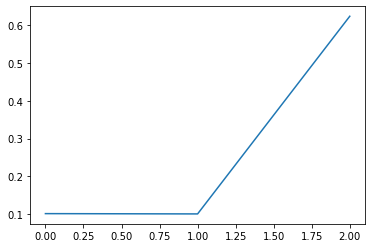

In [41]:
import matplotlib.pyplot as plt
plt.plot(range(num_epochs), acc_arr)
plt.show()

In [42]:
acc_arr[-1]

tensor(0.6238)

In [43]:
ratio = 4

small_conv_arch = [(pair[0], pair[1] // ratio) for pair in conv_arch]
small_conv_arch

[(1, 16), (1, 32), (2, 64), (2, 128), (2, 128)]

In [44]:
VGG_mini = vgg(small_conv_arch)

In [45]:
summary(VGG_mini.to(device),(1,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 224, 224]             160
              ReLU-2         [-1, 16, 224, 224]               0
         MaxPool2d-3         [-1, 16, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]           4,640
              ReLU-5         [-1, 32, 112, 112]               0
         MaxPool2d-6           [-1, 32, 56, 56]               0
            Conv2d-7           [-1, 64, 56, 56]          18,496
              ReLU-8           [-1, 64, 56, 56]               0
            Conv2d-9           [-1, 64, 56, 56]          36,928
             ReLU-10           [-1, 64, 56, 56]               0
        MaxPool2d-11           [-1, 64, 28, 28]               0
           Conv2d-12          [-1, 128, 28, 28]          73,856
             ReLU-13          [-1, 128, 28, 28]               0
           Conv2d-14          [-1, 128,

In [46]:
def vgg_mini(conv_arch):
    conv_blocks =[]
    in_channels=1
    
    for (num_convs, out_channels) in conv_arch:
        conv_blocks.append(vgg_block(num_convs, in_channels, out_channels))
        in_channels = out_channels
    
    return nn.Sequential(
        *conv_blocks,nn.Flatten(),
        nn.Linear(out_channels * 7 * 7, 512), nn.ReLU(), nn.Dropout(p=0.5),
        nn.Linear(512, 10)
    )

In [47]:
VGG_mini = vgg_mini(small_conv_arch)

In [48]:
summary(VGG_mini.to(device), (1,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 224, 224]             160
              ReLU-2         [-1, 16, 224, 224]               0
         MaxPool2d-3         [-1, 16, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]           4,640
              ReLU-5         [-1, 32, 112, 112]               0
         MaxPool2d-6           [-1, 32, 56, 56]               0
            Conv2d-7           [-1, 64, 56, 56]          18,496
              ReLU-8           [-1, 64, 56, 56]               0
            Conv2d-9           [-1, 64, 56, 56]          36,928
             ReLU-10           [-1, 64, 56, 56]               0
        MaxPool2d-11           [-1, 64, 28, 28]               0
           Conv2d-12          [-1, 128, 28, 28]          73,856
             ReLU-13          [-1, 128, 28, 28]               0
           Conv2d-14          [-1, 128,

In [49]:
look_in_net(VGG_mini, X)

For Class name : Sequential shape: torch.Size([32, 16, 112, 112])
For Class name : Sequential shape: torch.Size([32, 32, 56, 56])
For Class name : Sequential shape: torch.Size([32, 64, 28, 28])
For Class name : Sequential shape: torch.Size([32, 128, 14, 14])
For Class name : Sequential shape: torch.Size([32, 128, 7, 7])
For Class name : Flatten shape: torch.Size([32, 6272])
For Class name : Linear shape: torch.Size([32, 512])
For Class name : ReLU shape: torch.Size([32, 512])
For Class name : Dropout shape: torch.Size([32, 512])
For Class name : Linear shape: torch.Size([32, 10])


In [50]:
%%time
acc_arr = train_net(VGG_mini, num_epochs=3, lr=0.05)

Epoch 0 accuracy : 0.8061833381652832
Epoch 1 accuracy : 0.8065000176429749
Epoch 2 accuracy : 0.8069999814033508
Wall time: 5min 15s


In [51]:
acc_arr

[tensor(0.8062), tensor(0.8065), tensor(0.8070)]

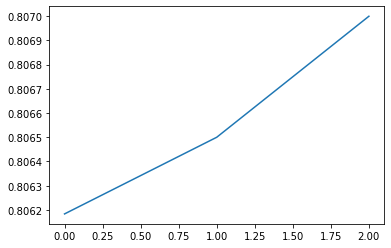

In [53]:
plt.plot(range(num_epochs), acc_arr)
plt.show()

In [73]:
del VGG_mini

#lets check the GPU memory
# import gc
# gc.collect()
# torch.cuda.empty_cache()

In [74]:
del ultra_small_net

In [77]:
torch.cuda.empty_cache()

In [75]:
VGG_mini = vgg(small_conv_arch) 

In [78]:
from torch_lr_finder import LRFinder

model = VGG_mini
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.05, weight_decay=1e-2)
lr_finder = LRFinder(model, optimizer, criterion, device=device)

lr_finder.range_test(train_dataloader, val_loader=test_dataloader, end_lr=1, num_iter=100, step_mode="linear")
lr_finder.plot(log_lr=False)
lr_finder.reset()

RuntimeError: CUDA out of memory. Tried to allocate 98.00 MiB (GPU 0; 4.00 GiB total capacity; 2.53 GiB already allocated; 49.23 MiB free; 2.67 GiB reserved in total by PyTorch)

In [70]:
%%time

acc_arr = train_net(vgg_mini, num_epochs=3)

RuntimeError: CUDA out of memory. Tried to allocate 50.00 MiB (GPU 0; 4.00 GiB total capacity; 2.64 GiB already allocated; 9.23 MiB free; 2.71 GiB reserved in total by PyTorch)

tensor(0.8070)


TypeError: imshow() missing 1 required positional argument: 'X'

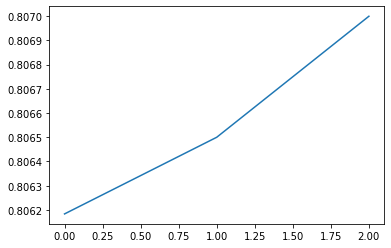

In [56]:
print(acc_arr[-1])
plt.plot(range(num_epochs), acc_arr)
plt.imshow()

In [79]:
VGG_19_arch = ((2,64), (2,128), (2,256), (4,512), (4,512))

VGG_16_arch = ((2,64), (2,128), (2,256), (3,512), (3,512))

In [83]:
VGG_19 = vgg(VGG_19_arch)
VGG_16 = vgg(VGG_16_arch)

try:
    VGG_19 = VGG_19.to(device)
    summary(VGG_19)
except Exception as e:
    print(e)



CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 4.00 GiB total capacity; 2.69 GiB already allocated; 7.23 MiB free; 2.71 GiB reserved in total by PyTorch)


In [84]:
try:
    VGG_16 = VGG_16.to(device)
    summary(VGG_16)
except Exception as e:
    print(e)

CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 4.00 GiB total capacity; 2.70 GiB already allocated; 5.23 MiB free; 2.71 GiB reserved in total by PyTorch)
